[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/lazzaronico/cytobench/blob/main/1%20understanding%20PED.ipynb)

In [1]:
import numpy as np
import scipy

import matplotlib.pyplot as plt
import seaborn as sns

# default figures style
sns.set(style='whitegrid')

# figures box size
figsize = 6

# set seed for reproducibility
np.random.seed(42)

# Pointwise Empirical Distance

The Pointwise Empirical Distance (PED) measures the average distance between each point in a reference distribution and the entire empirical distribution of another sample. It can be used to approximate the ND Wasserstein distance, which can be proven to be a PED upper bound when considering the Wasserstein distance of the pointwise distances distributions (as we will in this notebook). Using the Wasserstein distance the PED will approximate how much each point in a candidate empirical distribution needs to be "moved" to match the distribution of a reference empirical distribution (on average).

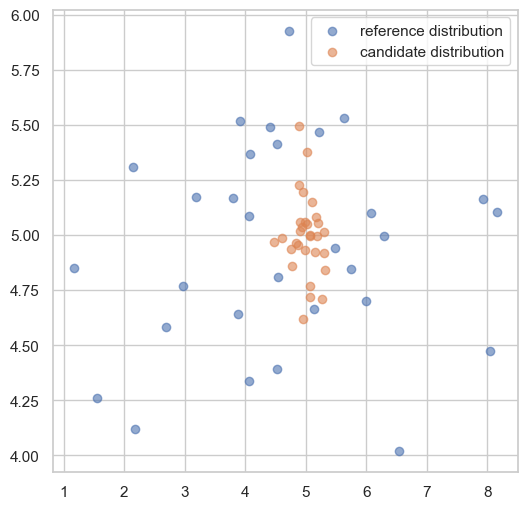

In [2]:
# generate a reference and candidate distribution in 2D
n_points = 30

reference_distribution = np.array([np.random.normal(5, 2, n_points), np.random.normal(5, .5, n_points)]).T
evaluated_distribution = np.array([np.random.normal(5, .2, n_points), np.random.normal(5, .2, n_points)]).T

plt.figure(figsize=(figsize, figsize))

plt.scatter(reference_distribution[:,0], reference_distribution[:,1], alpha=0.6, label='reference distribution')
plt.scatter(evaluated_distribution[:,0], evaluated_distribution[:,1], alpha=0.6, label='candidate distribution')

plt.legend()
plt.show()

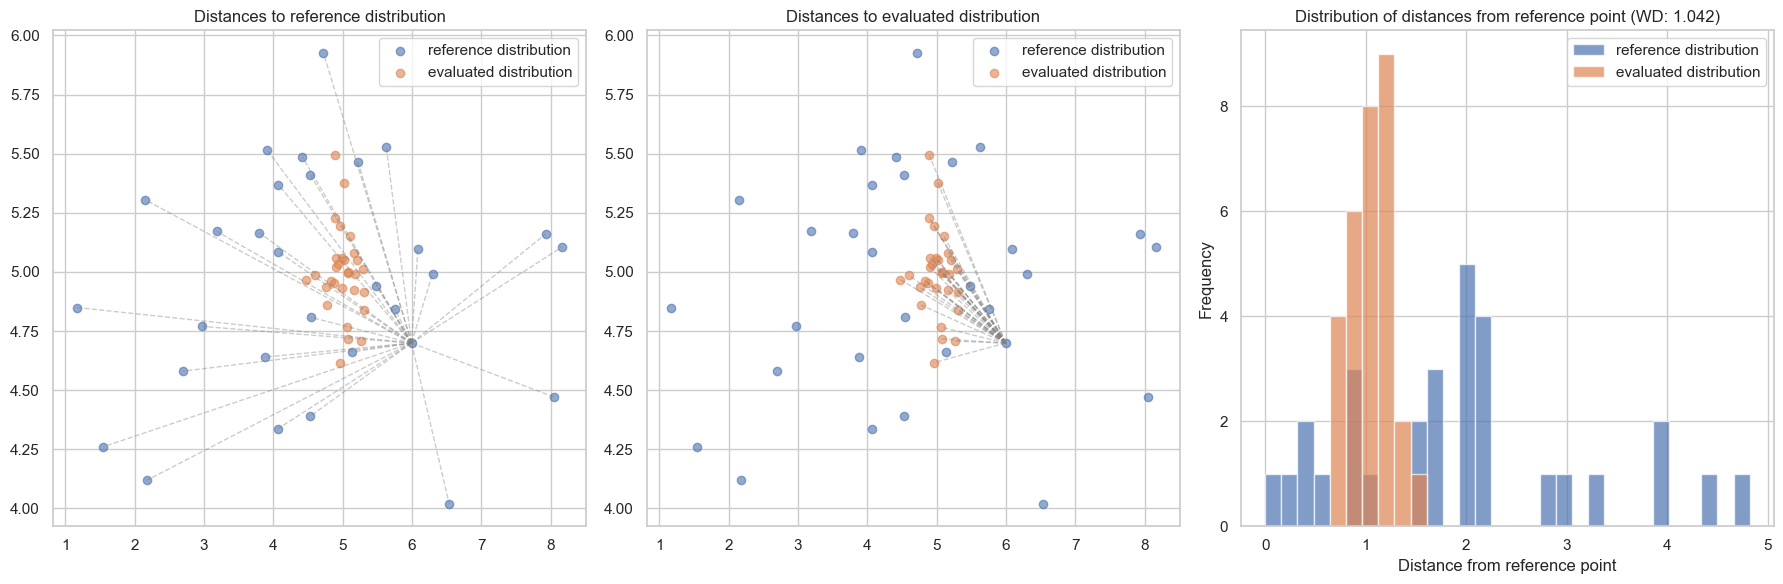

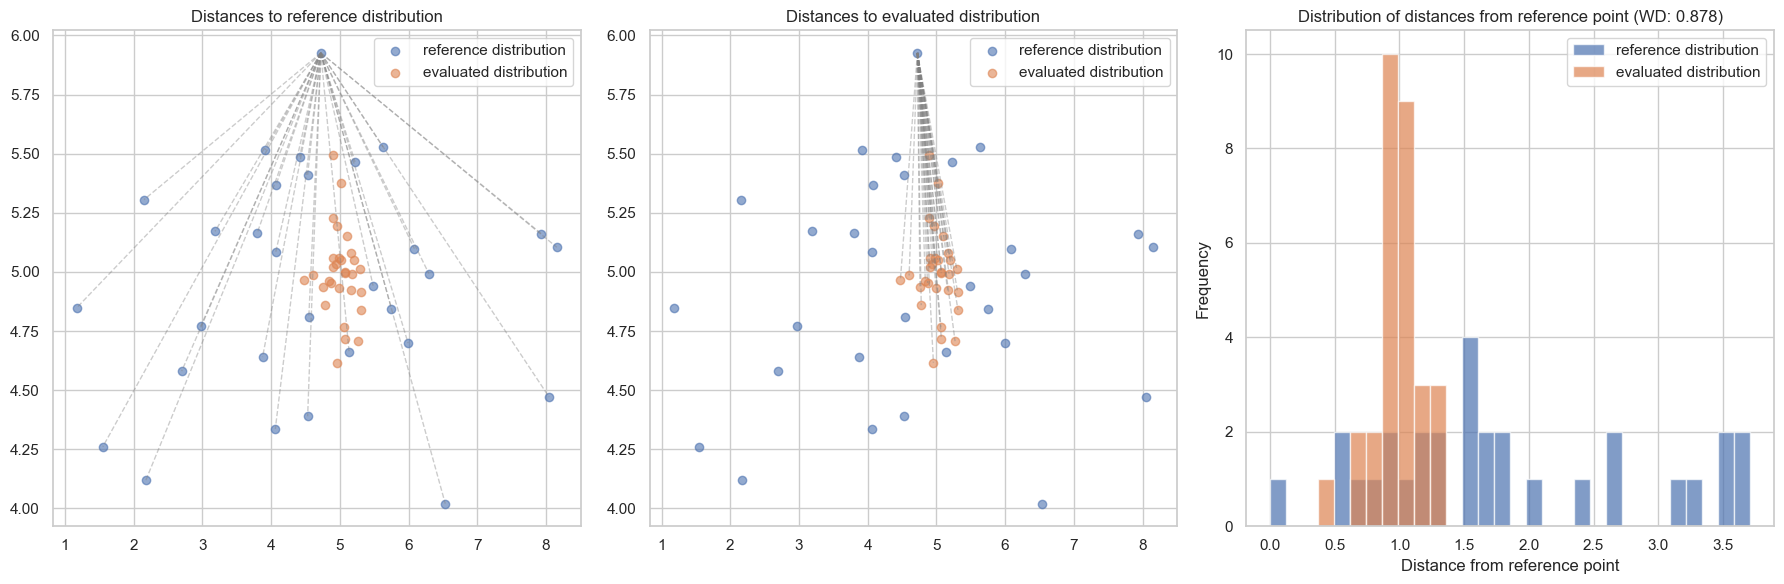

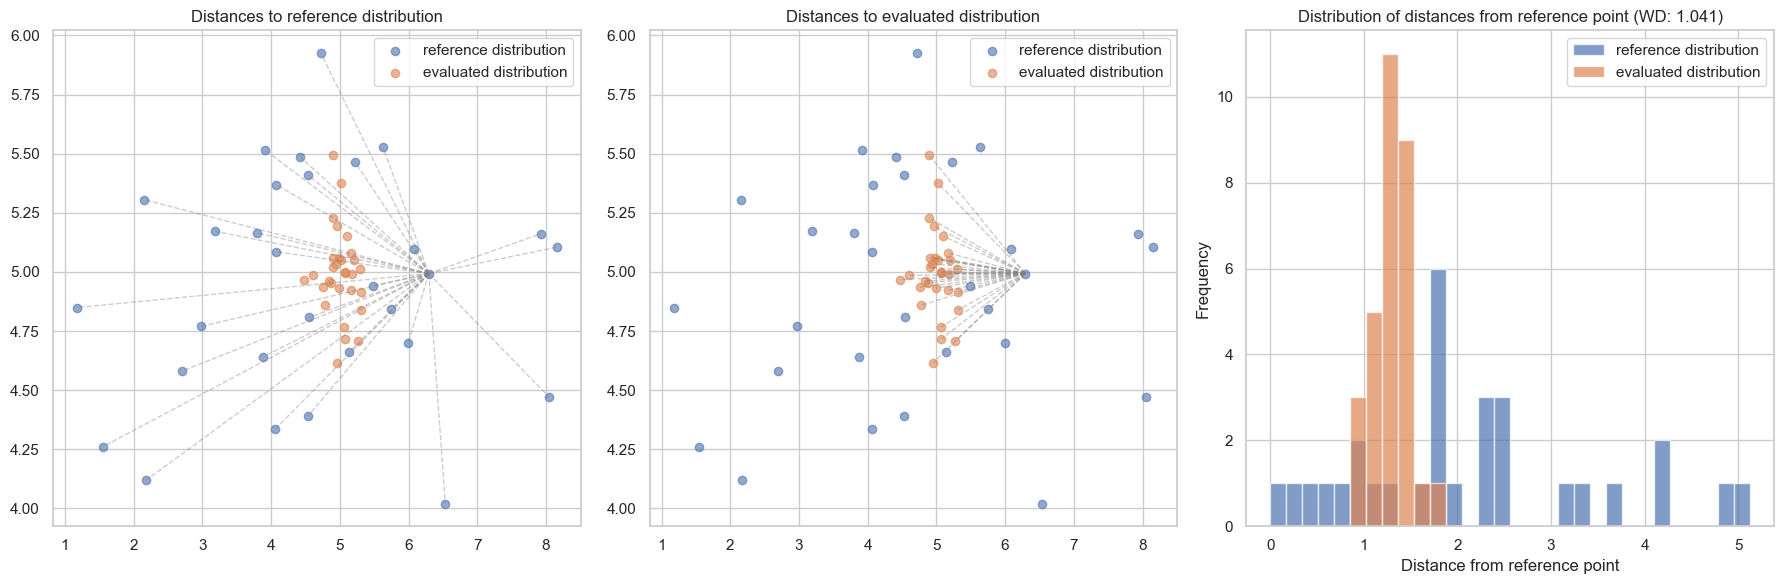

In [3]:
# the PED leverages every point in the reference samples to evaluate the average distance between empirical distributions;
# here we showcase how that looks like for a few of these points
for point_i in range(3):

    # 1) compute the distance between a reference point and the reference empirical distributions
    reference_point = reference_distribution[point_i]
    distances = np.linalg.norm(reference_distribution - reference_point, axis=1)

    plt.figure(figsize=(figsize*3, figsize))
    plt.subplot(1, 3, 1)
    
    for point in reference_distribution:
        plt.plot([reference_point[0], point[0]], [reference_point[1], point[1]], 'grey', linestyle='--', linewidth=1, alpha=.4)

    plt.scatter(reference_distribution[:,0], reference_distribution[:,1], alpha=0.6, label='reference distribution')
    plt.scatter(evaluated_distribution[:,0], evaluated_distribution[:,1], alpha=0.6, label='evaluated distribution')

    plt.legend(loc='upper right')
    plt.title('Distances to reference distribution')
    
    plt.subplot(1, 3, 2)
    
    # 2) compute the distance between the reference point and the evaluated empirical distributions
    distances = np.linalg.norm(reference_distribution - reference_point, axis=1)
    distances_eval = np.linalg.norm(evaluated_distribution - reference_point, axis=1)

    for point in evaluated_distribution:
        plt.plot([reference_point[0], point[0]], [reference_point[1], point[1]], 'grey', linestyle='--', linewidth=1, alpha=.4)

    plt.scatter(reference_distribution[:,0], reference_distribution[:,1], alpha=0.6, label='reference distribution')
    plt.scatter(evaluated_distribution[:,0], evaluated_distribution[:,1], alpha=0.6, label='evaluated distribution')

    plt.legend(loc='upper right')
    plt.title('Distances to evaluated distribution')

    plt.subplot(1, 3, 3)
    
    bins = np.histogram_bin_edges(np.concatenate([distances, distances_eval]), bins=n_points)

    plt.hist(distances, bins=bins, alpha=0.7, label='reference distribution')
    plt.hist(distances_eval, bins=bins, alpha=0.7, label='evaluated distribution')

    # 3) compare the two 1D distances distributions induced by the reference point
    wd = scipy.stats.wasserstein_distance(distances, distances_eval)

    plt.legend(loc='upper right')
    plt.xlabel('Distance from reference point')
    plt.ylabel('Frequency')
    plt.title(f'Distribution of distances from reference point (WD: {wd:.3f})')
    
    plt.tight_layout()
    plt.show()



The final Pointwise Empirical Distance is computed by considering the average distance metric between distances distributions

In [4]:
# we can use any distance defined in the space of interest; if it is a true distance, then the resulting 
# metric will have the properties of a true distance as well; in this case we'll use the euclidean distance
def distances(points, point):
    return np.linalg.norm(points - point, axis=1)

# the pointwise empirical distance can then be computed using any measure of distance between 1D distributions;
# in this notebook we'll use the wasserstein distance
def compute_ped(reference_samples, evaluated_samples):
    return np.mean([
        scipy.stats.wasserstein_distance(
            distances(reference_samples, reference_sample), 
            distances(evaluated_samples, reference_sample)
        ) 
        for reference_sample in reference_samples
    ])

# the above implementation does not yield a valid distance metric as it will be asymmetrical;
# for our practical purposes that works well, however if we want to have the computed PED be a real distance,
# we can simply average the otherwise asymmetric distance between the two distributions
def full_ped(reference_distribution, evaluated_distribution):
    return np.mean([compute_ped(reference_distribution, evaluated_distribution), compute_ped(evaluated_distribution, reference_distribution)])

print(f'PED between reference and evaluated distributions: {compute_ped(reference_distribution, evaluated_distribution):.2f} (complete: {full_ped(reference_distribution, evaluated_distribution):.2f})')
print(f'Wasserstein distance between reference and evaluated distributions: {scipy.stats.wasserstein_distance_nd(reference_distribution, evaluated_distribution):.2f}')

PED between reference and evaluated distributions: 1.01 (complete: 1.14)
Wasserstein distance between reference and evaluated distributions: 1.37


# Statistical interpretation

We can also use the PED to get a probability estimate of the two empirical distributions being generated from the same distribution.

In [5]:
def distances_distribution(samples, n_bootstrap = 1000):
    '''
    bootstrap pointwise empirical distances of an empirical distribution with respect to itself bootstrapped;
    return the resulting distances distribution, alongside the computed theoretical distribution
    '''
    # gather empirical PEDs
    peds = np.array([
        compute_ped(
            samples[np.random.choice(len(samples), len(samples))], 
            samples[np.random.choice(len(samples), len(samples))]
        ) for i in range(n_bootstrap)
    ])

    # in general these can be well approximated by a Gamma
    theoretical_distribution = scipy.stats.gamma(*scipy.stats.gamma.fit(peds))
    
    # return empirical and theoretical distribution
    return peds, theoretical_distribution

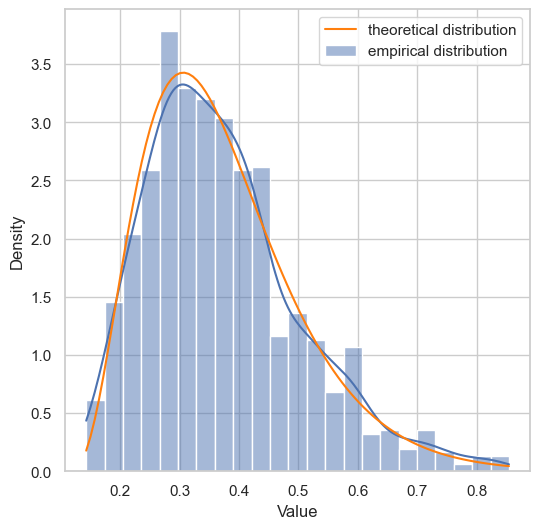

In [6]:
# compute empirical and theoretical distribution
peds, dist = distances_distribution(reference_distribution)

# plot empirical vs theoretical
plt.figure(figsize=(figsize, figsize))

# empirical distribution
sns.histplot(peds, stat='density', kde=True, label='empirical distribution')

# theoretical distribution
x = np.linspace(min(peds), max(peds), 100)
plt.plot(x, dist.pdf(x), label='theoretical distribution', color='#ff7f0e')

# label and plot
plt.xlabel('Value')
plt.ylabel('Density')
plt.legend()
plt.show()

We can therefore use the CDF of the fitted distribution for the expected PED to evaluate the probability of observing distances equal to or greater than the one registered for the evaluated distribution

In [7]:
# compute prob of observing a distance equal to or higher than the one observed from the candidate to the reference distribution
pval = 1 - dist.cdf(compute_ped(reference_distribution, evaluated_distribution))
print(f'Probability of candidate samples sharing ground distribution with empirical {pval:.4f}')

Probability of candidate distribution coming from empirical 0.0006


Notice that the evaluated distribution doesn't need to be unimodal, although complex distributions will require more samples to be compared

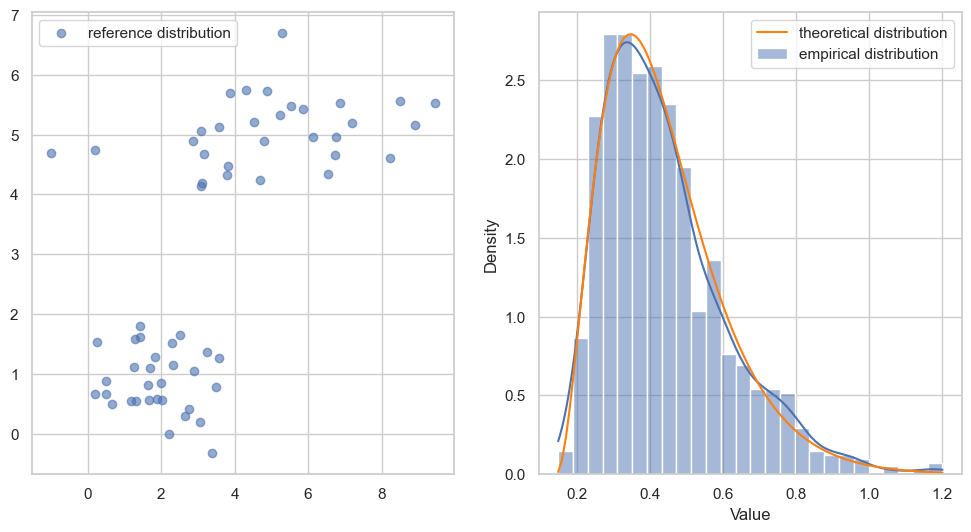

In [8]:
# simple multimodal distribution
reference_distribution = np.array([np.random.normal(5, 2, n_points), np.random.normal(5, .5, n_points)]).T
reference_distribution = np.concatenate([reference_distribution, np.array([np.random.normal(2, 1, n_points), np.random.normal(1, .5, n_points)]).T])

# compute empirical and theoretical distribution
peds, dist = distances_distribution(reference_distribution)

plt.figure(figsize=(figsize*2, figsize))

plt.subplot(1, 2, 1)
plt.scatter(reference_distribution[:,0], reference_distribution[:,1], alpha=0.6, label='reference distribution')
plt.legend()

plt.subplot(1, 2, 2)

sns.histplot(peds, stat='density', kde=True, label='empirical distribution')

# Plot the theoretical beta distribution
x = np.linspace(min(peds), max(peds), 100)
plt.plot(x, dist.pdf(x), label='theoretical distribution', color='#ff7f0e')

# Add labels and legend
plt.xlabel('Value')
plt.ylabel('Density')
plt.legend()
plt.show()

We document a few practical examples of how the pvalue might result from comparing different distributions (as well as cases in which the metric will fail)  
Notice that in general there will be no correlation between pointwise empirical distances and probability of distributions being close together, as they pertain two entirely different domains

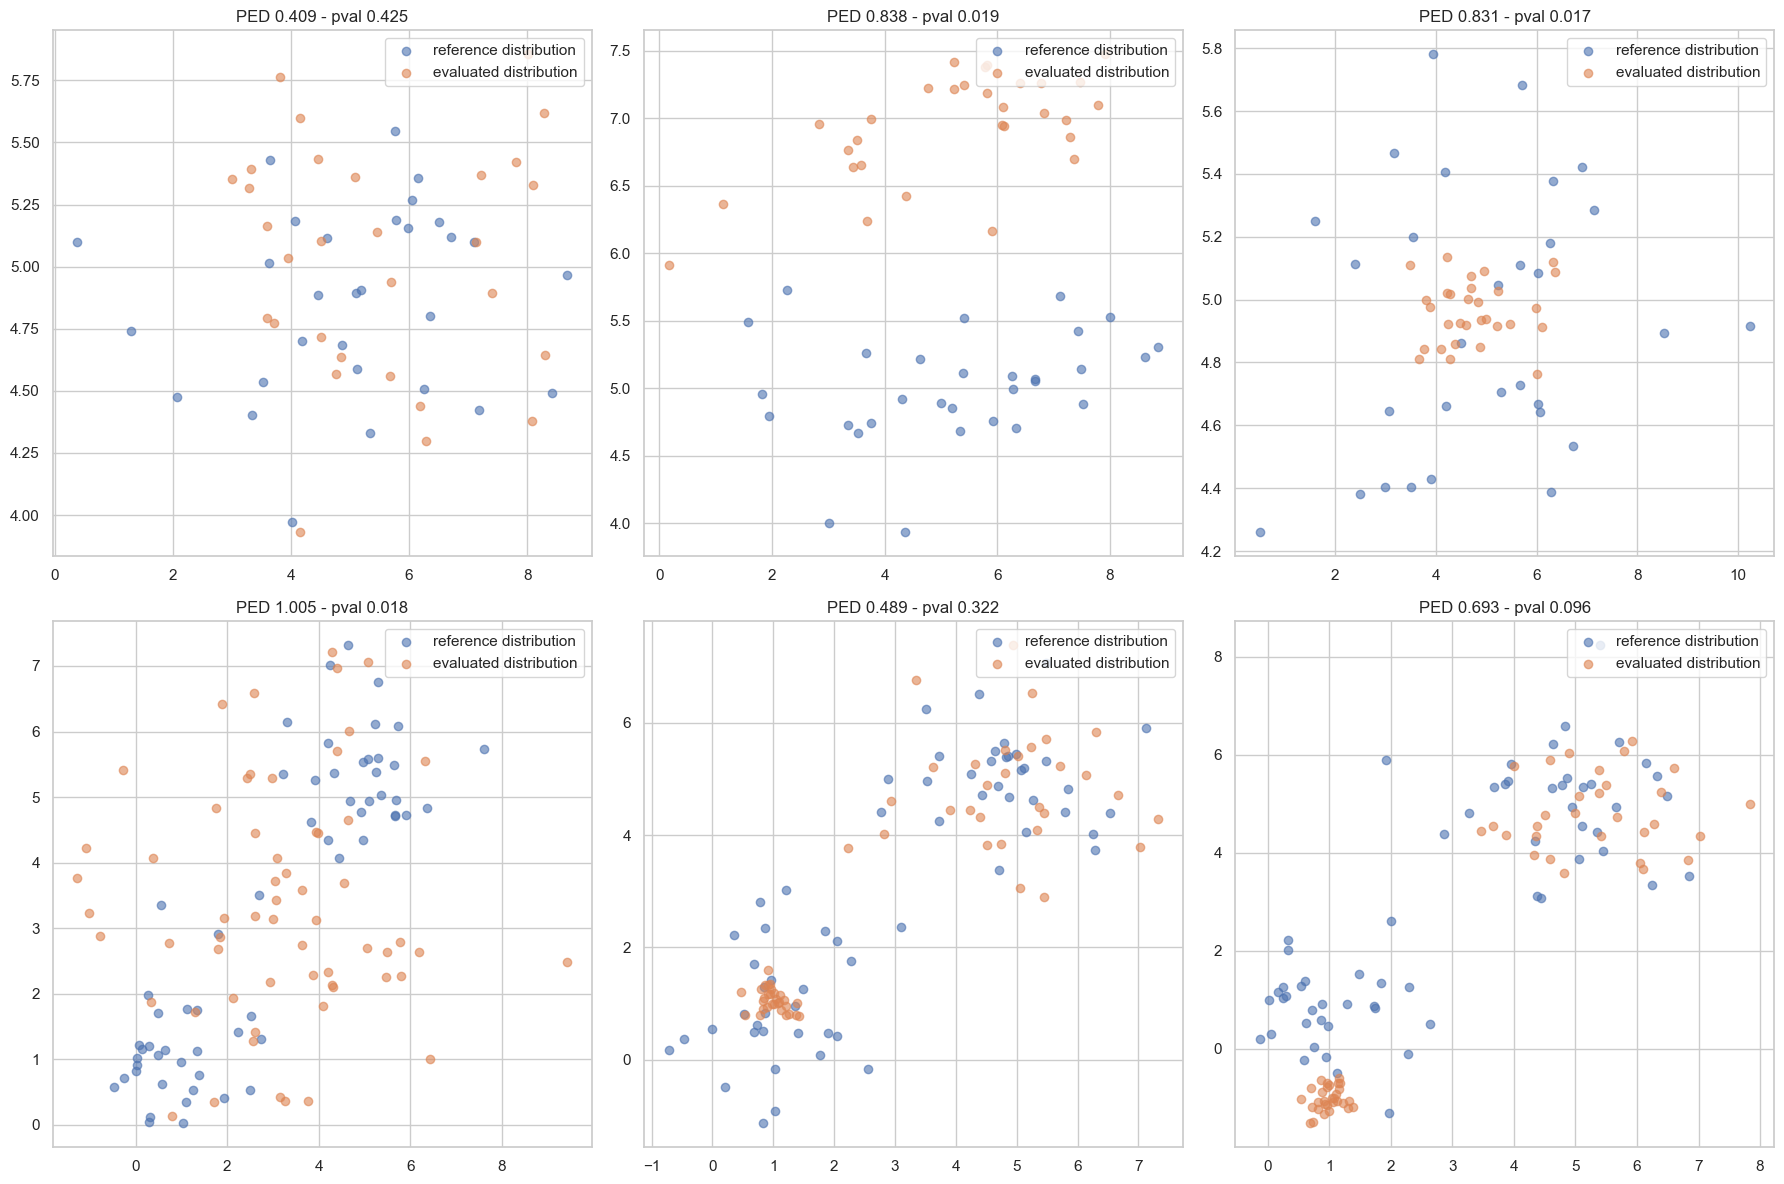

In [9]:
# list of normal distributions to compare
compare_dist = [
    
    # one element per example
    # for each example: reference and candidate
    # for each distribution: list of Gaussian mixtures
    # for each Gaussian: mean_x, mean_y, scale_x, scale_y
    
    [
        # identical distributions
        [[5, 5, 2, .5]],
        [[5, 5, 2, .5]],
    ],
    [
        # intersecting distributions
        [[5, 5, 2, .5]],
        [[5, 7, 2, .5]],
    ],
    [
        # concentric distributions
        [[5, 5, 2, .5]],
        [[5, 5, 1, .1]],
    ],
    
    [
        # multimodal vs unimodal
        [[5, 5, 1, 1], [1, 1, 1, 1]],
        [[3, 3, 2, 2], [3, 3, 2, 2]],
    ],
    [
        # concentric multimodal distributions, hard case
        [[5, 5, 1, 1], [1, 1, 1, 1]],
        [[5, 5, 1, 1], [1, 1, .2, .2]],
    ],
    [
        # concentric multimodal distributions, simple case
        [[5, 5, 1, 1], [1, 1, 1, 1]],
        [[5, 5, 1, 1], [1, -1, .2, .2]],
        
    ],
]

# plot initial population expansion on a 2x3 grid, flattening the axes for ease of iteration
fig, axes = plt.subplots(2, 3, figsize=(figsize*3, figsize*2))
axes = axes.flatten()

# increase sample size for visual clarity
n_samples = 60

for i in range(6):
    
    # sample points from reference distribution
    reference_distribution = np.concatenate([
        np.array([np.random.normal(mean_x, scale_x, n_points), np.random.normal(mean_y, scale_y, n_points)]).T
        for mean_x, mean_y, scale_x, scale_y in compare_dist[i][0]
    ])
    
    # sample points from evaluated distribution
    evaluated_distribution = np.concatenate([
        np.array([np.random.normal(mean_x, scale_x, n_points), np.random.normal(mean_y, scale_y, n_points)]).T
        for mean_x, mean_y, scale_x, scale_y in compare_dist[i][1]
    ])
    
    # compute PED and pval
    ped = compute_ped(reference_distribution, evaluated_distribution)
    pval = 1 - distances_distribution(reference_distribution)[1].cdf(ped)
    
    # plot distributions
    axes[i].scatter(reference_distribution[:,0], reference_distribution[:,1], alpha=0.6, label='reference distribution')
    axes[i].scatter(evaluated_distribution[:,0], evaluated_distribution[:,1], alpha=0.6, label='evaluated distribution')

    axes[i].legend(loc='upper right')
    axes[i].set_title(f'PED {ped:.3f} - pval {pval:.3f}')

plt.tight_layout()
plt.show()

Following some PED examples on more exotic distributions to wrap up the notebook, feel free to expand and play around with the functions by adding more!

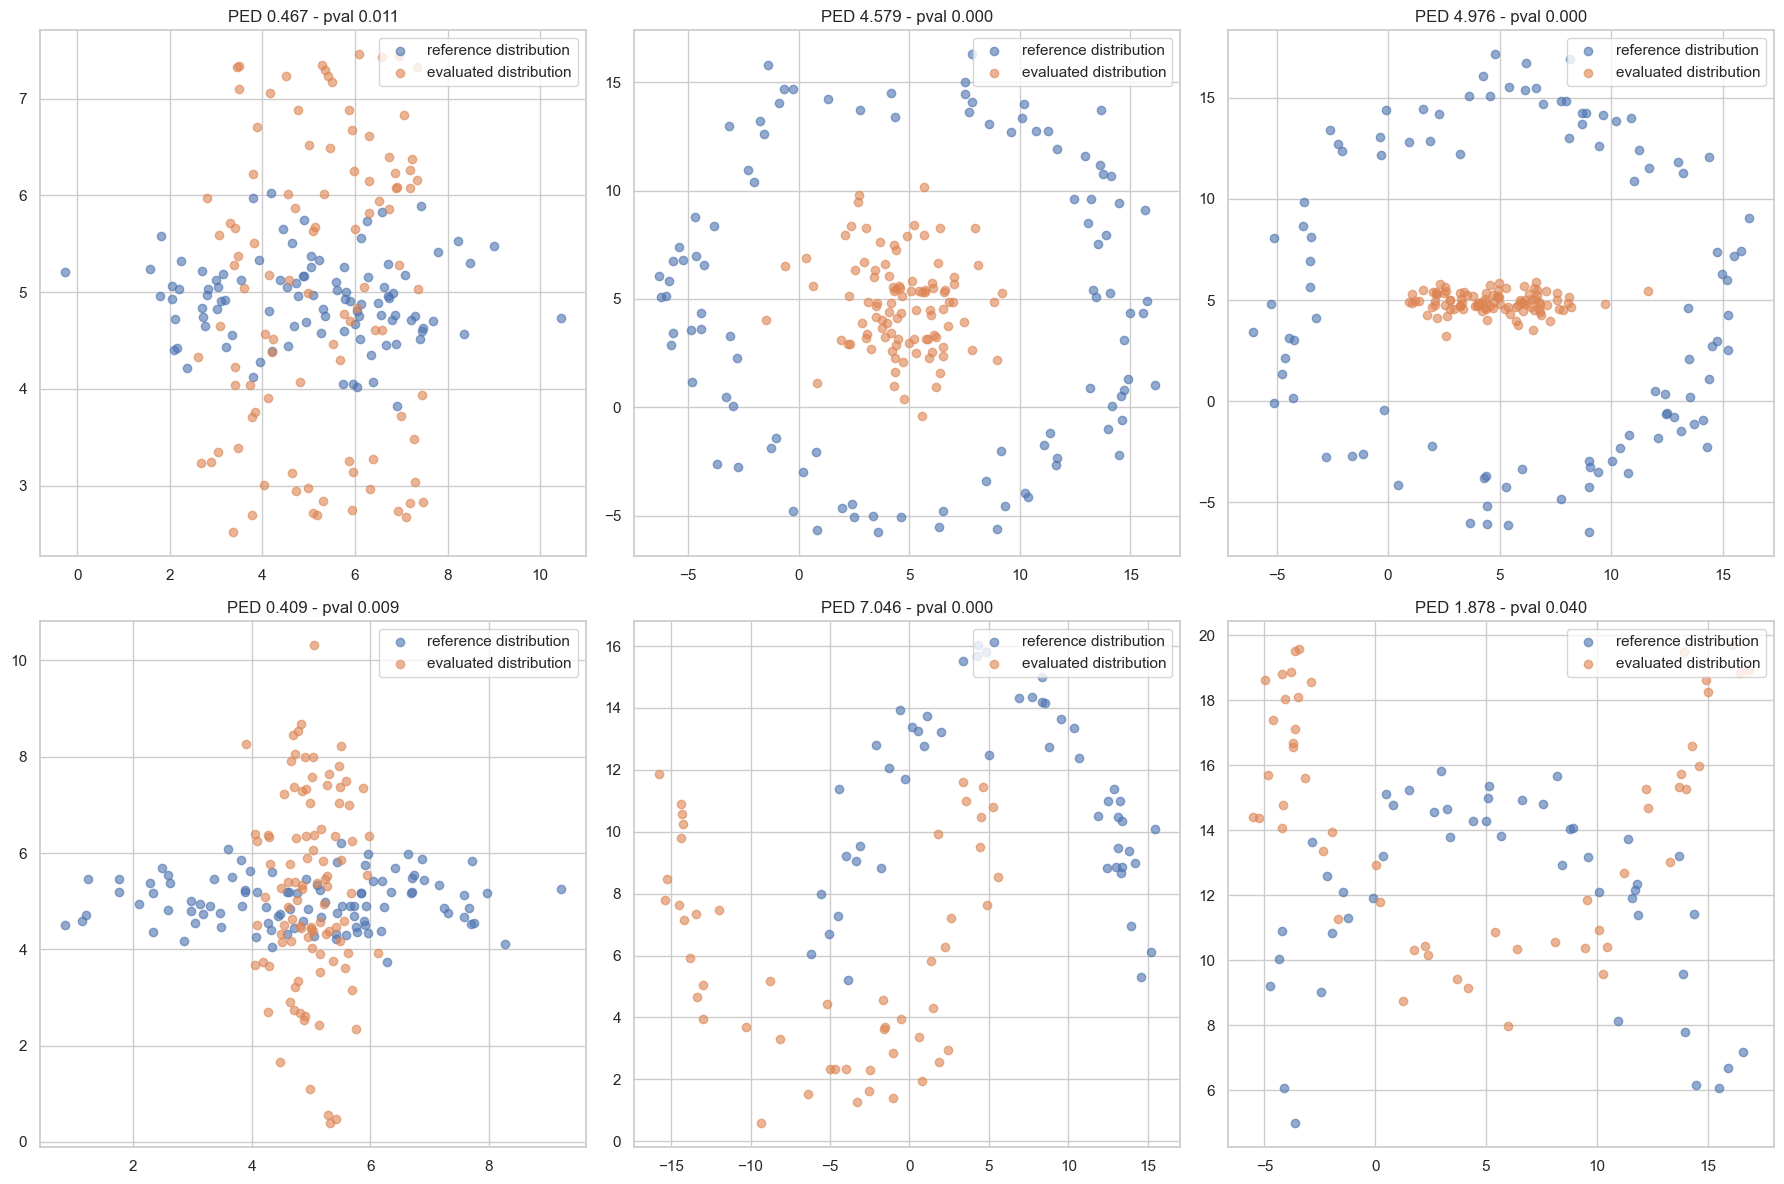

In [10]:
# extract plotting function from above
def compare_and_plot(axes, reference_distribution, evaluated_distribution):
    
    # compute PED and pval
    ped = compute_ped(reference_distribution, evaluated_distribution)
    pval = 1 - distances_distribution(reference_distribution)[1].cdf(ped)
    
    # plot distributions
    axes.scatter(reference_distribution[:,0], reference_distribution[:,1], alpha=0.6, label='reference distribution')
    axes.scatter(evaluated_distribution[:,0], evaluated_distribution[:,1], alpha=0.6, label='evaluated distribution')

    axes.legend(loc='upper right')
    axes.set_title(f'PED {ped:.3f} - pval {pval:.3f}')
    
# make some plots
fig, axes = plt.subplots(2, 3, figsize=(figsize*3, figsize*2))
axes = axes.flatten()

n_points, plot_i = 100, 0

# uniform vs normal, simple
reference_distribution = np.array([np.random.normal(5, 2, n_points), np.random.normal(5, .5, n_points)]).T
evaluated_distribution = np.array([np.random.uniform(2.5, 7.5, n_points), np.random.uniform(2.5, 7.5, n_points)]).T

compare_and_plot(axes[plot_i], reference_distribution, evaluated_distribution); plot_i += 1

# bullseye distribution
angles = np.random.uniform(0, 2 * np.pi, n_points)
radii = np.random.normal(10, 1, n_points)

reference_distribution = np.vstack((radii * np.cos(angles), radii * np.sin(angles))).T + 5
evaluated_distribution = np.array([np.random.normal(5, 2, n_points), np.random.normal(5, 2, n_points)]).T

compare_and_plot(axes[plot_i], reference_distribution, evaluated_distribution); plot_i += 1

# flattened bullseye
angles = np.random.uniform(0, 2 * np.pi, n_points)
radii = np.random.normal(10, 1, n_points)

reference_distribution = np.vstack((radii * np.cos(angles), radii * np.sin(angles))).T + 5
evaluated_distribution = np.array([np.random.normal(5, 2, n_points), np.random.normal(5, .5, n_points)]).T

compare_and_plot(axes[plot_i], reference_distribution, evaluated_distribution); plot_i += 1

# uniform vs normal
reference_distribution = np.array([np.random.normal(5, 2, n_points), np.random.normal(5, .5, n_points)]).T
evaluated_distribution = np.array([np.random.normal(5, .5, n_points), np.random.normal(5, 2, n_points)]).T

compare_and_plot(axes[plot_i], reference_distribution, evaluated_distribution); plot_i += 1

# non intersecting Us
angles = np.random.uniform(0, 2 * np.pi, n_points)
radii = np.random.normal(10, 1, n_points)
mask = angles < np.pi  # split into two distributions

reference_distribution = np.vstack((radii[mask] * np.cos(angles[mask]), radii[mask] * np.sin(angles[mask]))).T + 5
evaluated_distribution = np.vstack((radii[~mask] * np.cos(angles[~mask]), radii[~mask] * np.sin(angles[~mask]))).T + [-5, 12]

compare_and_plot(axes[plot_i], reference_distribution, evaluated_distribution); plot_i += 1

# intersecting Us
angles = np.random.uniform(0, 2 * np.pi, n_points)
radii = np.random.normal(10, 1, n_points)
mask = angles < np.pi  # split into two distributions

reference_distribution = np.vstack((radii[mask] * np.cos(angles[mask]), radii[mask] * np.sin(angles[mask]))).T + 5
evaluated_distribution = np.vstack((radii[~mask] * np.cos(angles[~mask]), radii[~mask] * np.sin(angles[~mask]))).T + [5, 20]

compare_and_plot(axes[plot_i], reference_distribution, evaluated_distribution); plot_i += 1

plt.tight_layout()
plt.show()